In [ ]:
pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 665.5 MB 10 kB/s 
     |████████████████████████████████| 463 kB 7.6 MB/s 
     |████████████████████████████████| 1.3 MB 33.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab202207

In [1]:
pip install tensorflow-quantum==0.6.0 --use-deprecated=legacy-resolver

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np 
import sympy as sp
import pandas as pd
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
from tensorflow_quantum.python.layers.circuit_construction import elementary
from cirq.contrib.svg import SVGCircuit
# from quple import ParameterisedCircuit
# import quple

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from google.colab import files
upload_file = files.upload()

Saving QIS_EXAM_200Events.npz to QIS_EXAM_200Events (4).npz


In [4]:
data = np.load('./QIS_EXAM_200Events.npz',allow_pickle = True)
X_train = data['training_input'].item()
X_test = data['test_input'].item()
# print(X_train['0'])
X_train_0 = X_train['0']
X_test_0 = X_test['0']
X_train_1 = X_train['1']
X_test_1 = X_test['1']


X_train = np.concatenate((X_train_0,X_train_1),axis=0)
X_test = np.concatenate((X_test_0,X_test_1),axis=0)

y_train = np.zeros((len(X_train),1))
y_test = np.zeros((len(X_test),1))
y_train[len(X_train_0):] = 1
y_test[len(X_test_0):] = 1
# print([d.T for d in [X_train_1, X_train_0] ])

print(X_train_0[0].shape)

(5,)


In [5]:
def make_plots(data, labels, binning=20, columns=3):
    X = [d.T for d in data]
    fig=plt.figure(figsize=(20, 10))
    rows =  1 + (X[0].shape[0] // columns)
    bins = np.histogram(np.hstack(tuple(X)), bins=binning)[1]
    plt.subplots_adjust(hspace=0.3)
    for i in range(X[0].shape[0]):
        ax = fig.add_subplot(rows, columns, i+1)
        ax.set_title('Variable {}'.format(i+1), fontsize=15)
        for j, x in enumerate(X):
            ax.hist(x[i], bins=bins, alpha=.5, label=labels[j])
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.2), ncol=len(data), fontsize=10)
    plt.show()

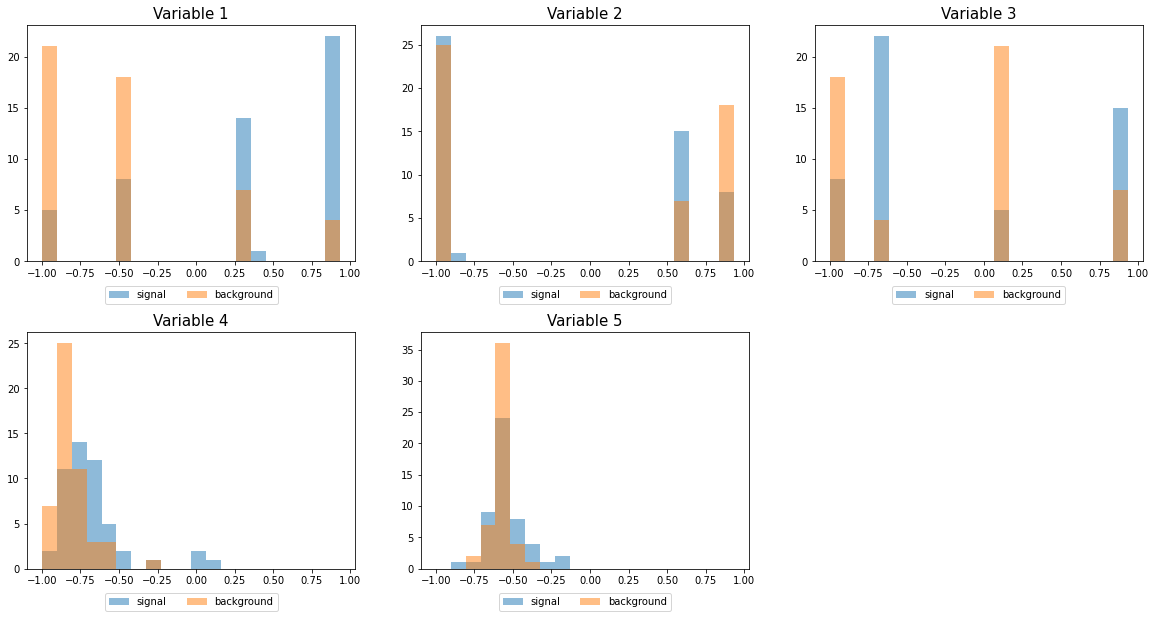

In [6]:
make_plots([X_train_1, X_train_0], ['signal', 'background'])

In [7]:
def one_qubit_unitary(qubits,symbols) -> cirq.Circuit :
  circuit = cirq.Circuit()
  # num_qubits = len(qubits)
  # k=0
  # for i in range(num_qubits):
  #   circuit.append(cirq.rx(symbols[k])(qubits[i]))
  #   k+=1
  # for i in range(num_qubits):
  #   circuit.append(cirq.ry(symbols[k])(qubits[i]))
  #   k+=1
  # for i in range(num_qubits):
  #   circuit.append(cirq.rz(symbols[k])(qubits[i]))
  #   k+=1
  circuit.append(cirq.rx(symbols[0])(qubits))
  circuit.append(cirq.ry(symbols[1])(qubits))
  circuit.append(cirq.rz(symbols[2])(qubits))
  return circuit

In [8]:
def two_qubit_unitary(qubits,symbols):
  circuit = cirq.Circuit()
  num_qubits = len(qubits)
  k=0
  for i in range(1,num_qubits,2):
    circuit.append(cirq.CNOT(qubits[i-1],qubits[i]))
    circuit.append(cirq.rz(symbols[k])(qubits[i]))
    circuit.append(cirq.CNOT(qubits[i-1],qubits[i]))
    k+=1
  
  return circuit

In [9]:
def entanglement_unitary(qubits,num_qubits):
  circuit = cirq.Circuit()
  for i in range(num_qubits):
    if i<num_qubits-1:
      circuit += cirq.CZ(qubits[i],qubits[i+1])
  if num_qubits!=2 : 
    circuit += cirq.CZ(qubits[num_qubits-1],qubits[0])
  return circuit

In [10]:
def generator_drc_circuit(qubits,features_size,use_entanglement=False, layers=1):
  circuit = cirq.Circuit()
  num_qubits = len(qubits)
  if(features_size % 3 != 0):
    padding = (3-(features_size % 3)) % 3
  else:
    padding = 0

  bias_symbols = sp.symbols('theta_:'+str((features_size + padding)*layers*num_qubits)) 
  bias_symbols = np.asarray(bias_symbols).reshape(layers,num_qubits,features_size+padding) 
  features_symbols = sp.symbols('x_:'+str((features_size + padding)*layers*num_qubits))
  features_symbols = np.asarray(features_symbols).reshape(layers,num_qubits,features_size+padding)
  gaussian_noise_shape = num_qubits
  # gaussian_noise_shape = num_qubits*layers
  z = np.random.normal(loc=0,scale=np.pi/4,size=gaussian_noise_shape)
  # z = np.clip(z,-0.9,0.9) 

  for layer in range(layers):
    for gate in range(int(np.ceil(features_size/3))):
      # circuit += [cirq.ry(z[layer:(layer+1)])(q) for q in qubits]
      circuit += [cirq.ry(z[i])(q) for i,q in enumerate(qubits)]
      circuit += [one_qubit_unitary(q, features_symbols[layer,i,gate*3:(gate+1)*3]) for i,q in enumerate(qubits)]
      circuit += [one_qubit_unitary(q, bias_symbols[layer,i,gate*3:(gate+1)*3]) for i,q in enumerate(qubits)]
      # circuit += [cirq.ry(z[layer:(layer+1)])(q) for q in qubits]
    if num_qubits>1 and (layer != layers-1 or layers == 1) and use_entanglement :
      circuit += entanglement_unitary(qubits,num_qubits)
  
  return circuit  

In [11]:
SVGCircuit(generator_drc_circuit(cirq.GridQubit.rect(1,2),5,use_entanglement = True, layers=3))

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


In [12]:
def discriminator_drc_circuit(qubits,features_size,use_entanglement=False, layers=1):
  circuit = cirq.Circuit()
  num_qubits = len(qubits)
  if(features_size % 3 != 0):
    padding = (3-(features_size % 3)) % 3
  else:
    padding = 0

  bias_symbols = sp.symbols('theta_:'+str((features_size + padding)*layers*num_qubits)) 
  bias_symbols = np.asarray(bias_symbols).reshape(layers,num_qubits,features_size+padding) 
  features_symbols = sp.symbols('x_:'+str((features_size + padding)*layers*num_qubits))
  features_symbols = np.asarray(features_symbols).reshape(layers,num_qubits,features_size+padding)
  # gaussian_noise_shape = num_qubits
  gaussian_noise_shape = num_qubits*layers
  z = np.random.normal(loc=0,scale=np.pi/4,size=gaussian_noise_shape)
  # z = np.clip(z,0,1)
  
  for layer in range(layers):
    for gate in range(int(np.ceil(features_size/3))):
      # circuit += [cirq.ry(z[layer:(layer+1)])(q) for q in qubits]
      circuit += [cirq.ry(z[i])(q) for i,q in enumerate(qubits)]
      circuit += [one_qubit_unitary(q, features_symbols[layer,i,gate*3:(gate+1)*3]) for i,q in enumerate(qubits)]
      circuit += [one_qubit_unitary(q, bias_symbols[layer,i,gate*3:(gate+1)*3]) for i,q in enumerate(qubits)]
      # circuit += [cirq.ry(z[layer:(layer+1)])(q) for q in qubits]
    if num_qubits>1 and (layer != layers-1 or layers == 1) and use_entanglement :
      circuit += entanglement_unitary(qubits,num_qubits)
  
  return circuit, list(bias_symbols.flat), list(features_symbols.flat)

In [13]:
class ReUploadingPQC(tf.keras.layers.Layer):
    def __init__(self, n_qubits, n_layers,features_size , use_entanglement=True, name="re-uploading_PQC"):     #filter_size
        super(ReUploadingPQC, self).__init__(name=name)
        self.n_layers = n_layers
        self.n_qubits = n_qubits
        # self.filter_size = filter_size
        self.features_size = features_size
        self.use_entanglement = use_entanglement
        self.main_name = name

        self.qubits = cirq.GridQubit.rect(1, n_qubits)
        self.observables = [cirq.Z(self.qubits[-1])]  # Measure only the last qubit

        # generate the data re-uploading circuit
        # circuit, bias_symbols, input_symbols = generate_circuit(self.qubits, self.n_layers, self.filter_size, use_entanglement=self.use_entanglement)
        circuit, bias_symbols, input_symbols = discriminator_drc_circuit(qubits=self.qubits,features_size = self.features_size,layers= self.n_layers, use_entanglement=self.use_entanglement)

        # Define explicit symbol order.
        symbols = [str(symb) for symb in bias_symbols + input_symbols]
        self.indices = tf.constant([sorted(symbols).index(a) for a in symbols])

        # thetas (bias) initialization
        thetas_init = tf.random_uniform_initializer(minval=-1, maxval=1)
        self.thetas = tf.Variable(
            initial_value=thetas_init(shape=(1, len(bias_symbols)), dtype="float32"),
            trainable=True, name=self.main_name + "-thetas"
        )
        
        # weights initialization
        w_init = tf.random_uniform_initializer(minval=-1, maxval=1)
        self.w = tf.Variable(
            initial_value=w_init(shape=(1, len(input_symbols)), dtype="float32"),
            trainable=True, name=self.main_name + "-weights"
        )

        # dummy inputs initialization
        # using the empty circuits as hacks for ControlledPQC
        self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])

        self.computation_layer = tfq.layers.ControlledPQC(circuit, self.observables)
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_qubits': self.n_qubits,
            'n_layers': self.n_layers,
            'features_size': self.features_size,
            'use_entanglement': self.use_entanglement,
            'name': self.main_name,
        })
        return config
    
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        # Flatten inputs (from 2D images to 1D array)
        # inputs_flattened = tf.keras.layers.Flatten()(inputs)

        # Pad the inputs if it is not a multiple of 3
        # padding = 3 - inputs_flattened.shape[1]%3
        # padding = 3 - inputs.shape[0]%3
        padding = 3 - inputs.shape[1]%3
        # padding = 1
        if padding%3 != 0:
            # inputs_flattened = tf.pad(inputs_flattened, tf.constant([[0, 0,], [0, padding]]))
            inputs = tf.pad(inputs,tf.constant([[0,0],[0,padding]]),mode="CONSTANT")
        # Repeat the inputs for every layer and qubit
        # inputs_flattened = tf.tile(inputs_flattened, tf.constant([1,self.n_layers*self.n_qubits]))
        total_inputs = tf.tile(inputs, multiples=[1,self.n_layers*self.n_qubits])
        # total_inputs = tf.tile(inputs, multiples=[1,self.n_layers])
        # Weight the inputs
        # inputs_weighted = tf.math.multiply(self.w, inputs_flattened, name=self.main_name + '-weighted_inputs')  
        inputs_weighted = tf.math.multiply(self.w, total_inputs, name=self.main_name + '-weighted_inputs')
        # Duplicate parameters and dummy inputs
        # One for every batch
        thetas_batch = tf.tile(self.thetas, multiples=[batch_size, 1], name=self.main_name + '-tiled_up_thetas')    
        empty_circuit_batch = tf.repeat(self.empty_circuit, repeats=batch_size, name=self.main_name + '-tiled_up_empty_circuits')

        joined_params = tf.concat([thetas_batch, inputs_weighted], axis=-1)               
        # joined_params = tf.concat([self.thetas, inputs_weighted], axis=-1)
        joined_params = tf.gather(joined_params, self.indices, axis=-1, name=self.main_name + '-joined_params')
        
        return self.computation_layer([empty_circuit_batch, joined_params])
        # return self.computation_layer([self.empty_circuit, joined_params])

In [14]:
def discriminator_layer(n_qubits,features_size,inputs,use_entanglement=False,layers=1,name="discriminator_drc_layer"):
  # inputs_tensor = tf.keras.Input(shape=(features_size,),dtype=tf.dtypes.float32,name="inputs")
  # drc = data_reuploading(qubits,features_size,use_entanglement=True,layers=layers,inputs=inputs_tensor)
  # model = tf.keras.Sequential()
  # model.add(tf.keras.layers.Input(shape=(5),name="input"))
  # model.add(data_reuploading(qubits,features_size,use_entanglement=True,layers=layers,inputs=))
  # model = tf.keras.Model(inputs=[inputs_tensor],outputs=[drc])
  # return model
  pqc = ReUploadingPQC(n_qubits=n_qubits,features_size=features_size,use_entanglement=use_entanglement,n_layers=layers,name= name)
  computations = pqc(inputs)
  return computations

In [15]:

qubits = 2
features=len(X_train_0[0])
layers= 3
inputs_tensor = tf.keras.Input(shape=(features,),dtype = tf.dtypes.float32,name='input')
d_layer = discriminator_layer(n_qubits=qubits,features_size=features,inputs=inputs_tensor, use_entanglement=True,layers=layers)
output_layer = tf.keras.layers.Dense(1, activation=tf.keras.layers.LeakyReLU(alpha=0.01))
outputs = output_layer(d_layer)
# discriminator_model = tf.keras.Model(inputs=[inputs_tensor], outputs=d_layer)
discriminator_model = tf.keras.Model(inputs=[inputs_tensor], outputs=outputs)

In [16]:
discriminator_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 5)]               0         
                                                                 
 discriminator_drc_layer (Re  (None, 1)                72        
 UploadingPQC)                                                   
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 74
Trainable params: 74
Non-trainable params: 0
_________________________________________________________________


In [17]:
def one_qubit_unitary_pqc(qubits,symbols) -> cirq.Circuit :
  num_qubits = len(qubits)
  circuit = cirq.Circuit()
  k=0
  for i in range(num_qubits):
    circuit.append(cirq.rx(symbols[k])(qubits[i]))
    k+=1
  for i in range(num_qubits):
    circuit.append(cirq.rz(symbols[k])(qubits[i]))
    k+=1
  
  return circuit

In [18]:
def two_qubit_unitary_pqc(qubits,symbols):
  num_qubits = len(qubits)
  circuit = cirq.Circuit()
  k=0
  for i in range(1,num_qubits,2):
    circuit.append(cirq.CNOT(qubits[i-1],qubits[i]))
    circuit.append(cirq.rz(symbols[k])(qubits[i]))
    circuit.append(cirq.CNOT(qubits[i-1],qubits[i]))
    k+=1
  
  for i in range(2,num_qubits,2):
    circuit.append(cirq.CNOT(qubits[i-1],qubits[i]))
    circuit.append(cirq.rz(symbols[k])(qubits[i]))
    circuit.append(cirq.CNOT(qubits[i-1],qubits[i]))
    k+=1
  return circuit

In [19]:
def generator_pqc_circuit(qubits,use_entanglement=True,layers=1):
  circuit = cirq.Circuit()
  num_qubits = len(qubits)
  # num_data_qubits = int(num_qubits/2)
  symbols = sp.symbols('G_theta1_:'+str(2*layers*num_qubits)) + sp.symbols('G_theta2_:'+str(layers*(num_qubits-1)))
  symbols_one = symbols[:2*layers*num_qubits]
  symbols_two = symbols[2*layers*num_qubits:]
  # random_rotations = np.random.normal(loc=0.0,scale=np.pi/4,size=num_qubits)
  # for i in range(num_qubits):
  #   circuit.append(cirq.ry(random_rotations[i])(qubits[i]))
  # k=0
  for l in range(layers):
    circuit += one_qubit_unitary_pqc(qubits,symbols_one[l*2*num_qubits:(l+1)*2*num_qubits])
    if(use_entanglement):
      circuit += two_qubit_unitary_pqc(qubits,symbols_two[l*(num_qubits-1):(l+1)*(num_qubits-1)])
  
  return circuit,symbols

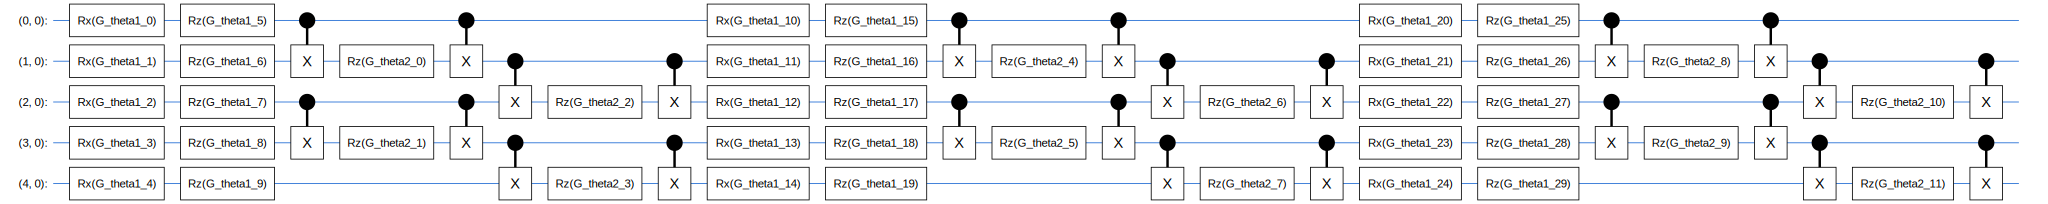

In [20]:
circ,symbols = generator_pqc_circuit(cirq.GridQubit.rect(5,1),layers=3)
SVGCircuit(circ)

In [21]:
def data_encoding_circuit(qubits):
  circuit = cirq.Circuit()
  input_symbols = sp.symbols('x_:'+str(len(qubits)))
  for i,q in enumerate(qubits):
    circuit += cirq.ry(input_symbols[i])(q)
  return circuit,input_symbols

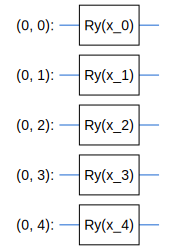

In [22]:
SVGCircuit(data_encoding_circuit(cirq.GridQubit.rect(1,5))[0])

In [23]:
class GeneratorPQC(tf.keras.layers.Layer):
  def __init__(self,data_circuit,variational_circuit,n_qubits,use_entanglement=True,name = "GeneratorPQC"):
    super(GeneratorPQC,self).__init__(name=name)
    self.n_qubits=n_qubits
    # self.n_layers=n_layers
    self.use_entanglement=use_entanglement
    self.main_name = name
    # self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])
    # self.qubits = cirq.GridQubit.rect(1, n_qubits)
    # self.observables = [cirq.Z(q) for q in self.qubits]
    self.append_layer = elementary.AddCircuit()
    # circuit,symbols,input_symbols = generator_pqc_circuit(qubits=self.qubits,layers=self.n_layers)
    self.encoding_circuit,self.input_symbols = data_circuit
    self.encoding_circuit = tfq.convert_to_tensor([self.encoding_circuit])
    # data_circuit = QuantumCircuit.from_cirq(data_circuit)
    self.op_circuit,self.param_symbols = variational_circuit
    self.op_circuit = tfq.convert_to_tensor([self.op_circuit])
    # variational_circuit = QuantumCircuit.from_cirq(variational_circuit)
    self.operators = [cirq.Z(q) for q in variational_circuit[0].all_qubits()]
    self.parameters = self.add_weight('parameters',
                                          shape=(1,len(self.param_symbols)),
                                          # initializer=self.initializer,
                                          # regularizer=self.regularizer,
                                          # constraint=self.constraint,
                                          dtype=tf.float32,
                                          trainable=True)
    self.demo_circuit = data_circuit[0] +variational_circuit[0]
    symbols = [str(symb) for symb in self.input_symbols + self.param_symbols]
    self.indices = tf.constant([sorted(symbols).index(a) for a in symbols])
    # thetas_init = tf.random_uniform_initializer(minval=-np.pi/2, maxval=np.pi/2)
    # self.params = tf.Variable(
    #         initial_value=thetas_init(shape=(1, symbols), dtype="float32"),
    #         trainable=True, name=self.main_name + "thetas")
    self.computation_layer = tfq.layers.ControlledPQC(self.demo_circuit,self.operators)
    
  def get_config(self):
    config = super().get_config().copy()
    config.update({
            'n_qubits': self.n_qubits,
            'n_layers': self.n_layers,
            'use_entanglement': self.use_entanglement,
            'name': self.main_name,
    })
    return config
  
  def call(self,inputs):
    batch_size = tf.shape(inputs)[0]
    tiled_encoding_circuit = tf.tile(self.encoding_circuit,[batch_size])
    tiled_variational_circuit = tf.tile(self.op_circuit,[batch_size])
    # full_circuit_batch = self.append_layer(tiled_encoding_circuit,tiled_variational_circuit)
    full_circuit_batch = tfq.layers.AddCircuit()(tiled_encoding_circuit,append=tiled_variational_circuit)
    # empty_circuit_batch = tf.repeat(self.empty_circuit, repeats=batch_size, name=self.main_name + '-tiled_up_empty_circuits') 
    tiled_parameters = tf.tile(self.parameters, multiples=[batch_size,1], name=self.main_name + '-tiled_up_empty_thetas') 
    joined_params = tf.concat([inputs,tiled_parameters],axis=-1)
    
    # joined_params = tf.gather(joined_params,self.indices,axis=-1,name=self.main_name + '-joined_parameters')
    # tiled_operators = tf.tile(self.operators,[batch_size,1])
    # return self.computation_layer([empty_circuit_batch,self.parameters])
    return self.computation_layer([full_circuit_batch,joined_params])

In [24]:
n_gen_qubits = len(X_train_0[0])
qubits = cirq.GridQubit.rect(n_gen_qubits,1)
layers = 5
observables = [cirq.Z(q) for q in qubits]
inputs = tf.keras.Input(shape=(n_gen_qubits,))      #,dtype = tf.dtypes.float32
gen_pqc = GeneratorPQC(data_circuit=data_encoding_circuit(cirq.GridQubit.rect(n_gen_qubits,1)),variational_circuit=generator_pqc_circuit(cirq.GridQubit.rect(n_gen_qubits,1),layers=layers),n_qubits=n_gen_qubits)
gen_pqc_layer = gen_pqc(inputs)
# g_layers = tfq.layers.ControlledPQC(generator_pqc_circuit(qubits,layers),observables)(inputs)
generator_model = tf.keras.Model(inputs=[inputs],outputs=[gen_pqc_layer])

In [25]:
generator_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 GeneratorPQC (GeneratorPQC)  (None, 5)                70        
                                                                 
Total params: 70
Trainable params: 70
Non-trainable params: 0
_________________________________________________________________


In [26]:
def prepare_dataset(data,batch_size,seed=None,drop_remainder=True,buffer_size=100):
  buffer_size =len(data[0])
  ds = tf.data.Dataset.from_tensor_slices(data)
  ds = ds.shuffle(buffer_size=buffer_size,seed=seed,reshuffle_each_iteration=True)
  ds = ds.batch(batch_size,drop_remainder)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [27]:
def train_preprocess(random_state):
  tf.random.set_seed(random_state)
  np.random.seed(random_state)

In [28]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function
def generator_loss(fake_output):
  return loss(tf.ones_like(fake_output),fake_output)

@tf.function
def discriminator_loss(real_output,fake_output):
  real_loss = loss(tf.ones_like(real_output),real_output)
  fake_loss = loss(tf.zeros_like(fake_output),fake_output)
  return real_loss + fake_loss

In [29]:
identifier_d = {"class_name": 'adam', "config": {"learning_rate": 1e-4}}
identifier_g = {"class_name": 'adam', "config": {"learning_rate": 5e-4}}
discriminator_optimizer = tf.keras.optimizers.get(identifier_d)
generator_optimizer = tf.keras.optimizers.get(identifier_g)

In [30]:
from tensorflow.python.eager.backprop import GradientTape
@tf.function
def discriminator_step(x_real,batch_size):
  fake_data_shape = (batch_size,) + generator_model.input_shape[1:]
  x_real = tf.reshape(x_real,fake_data_shape)
  z = tf.random.normal(shape=fake_data_shape)
  with tf.GradientTape() as gradient_tape:
    real_output = discriminator_model(x_real,training = True)
    fake_input = generator_model(z, training = True)
    # fake_input = tf.reshape(fake_input, tf.shape(x_real))
    fake_output = discriminator_model(fake_input,training = True)
    cost = discriminator_loss(real_output,fake_output)
  grad = gradient_tape.gradient(cost,discriminator_model.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(grad,discriminator_model.trainable_variables))
  return cost

In [31]:
@tf.function
def generator_step(batch_size):
  fake_data_shape = (batch_size,) + generator_model.input_shape[1:]
  z = tf.random.normal(shape=fake_data_shape)
  with tf.GradientTape() as gradient_tape:
    fake_input = generator_model(z,training=True)
    fake_output = discriminator_model(fake_input,training= True) 
    loss = generator_loss(fake_output)
  grad = gradient_tape.gradient(loss,generator_model.trainable_variables)
  generator_optimizer.apply_gradients(zip(grad,generator_model.trainable_variables))
  return loss

In [32]:
@tf.function
def train_step_1v1(x_real,batch_size):
  
  """Training step for one epoch with 1 generator step and 1 discriminator step
        """
  fake_data_shape = (batch_size,) + generator_model.input_shape[1:]
  z = tf.random.normal(shape=fake_data_shape)
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    x_fake_ = generator_model(z, training=True)
    # x_fake = tf.reshape(x_fake_, tf.shape(x_real))
    real_output = discriminator_model(x_real, training=True)
    fake_output = discriminator_model(x_fake_, training=True)
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
  grad_gen = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
  grad_disc = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)
  generator_optimizer.apply_gradients(zip(grad_gen, generator_model.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(grad_disc, discriminator_model.trainable_variables))  
  return gen_loss, disc_loss

In [33]:
@tf.function
def train_step_nv1(x_real,n_disc,batch_size):
  for i in range(n_disc):
    x_real_batch = tf.gather(x_real,i)
    d_loss = discriminator_step(x_real_batch,batch_size)
  g_loss = generator_step(batch_size)
  return g_loss, d_loss

In [34]:
@tf.function
def train_step_1vn(x_real,n_gen,batch_size):
  for i in range(n_gen):
    g_loss = generator_step(batch_size)
  d_loss = discriminator_step(x_real,batch_size)
  return g_loss, d_loss 

In [35]:
gen_loss_ = []
disc_loss_ = []
epochs_ = []

In [36]:
def train_qgans(x,epochs,batch_size,seed=1024,n_disc=1,n_gen=1):
  input_shape = x.shape[1:]
  train_preprocess(seed)
  data = prepare_dataset(data=x,batch_size=batch_size*n_disc,seed=seed)
  g_metric = tf.keras.metrics.Mean()
  d_metric = tf.keras.metrics.Mean()
  for epoch in range(epochs):
    for step,training_batch_data_ in enumerate(data):
      # training_batch_data = tf.reshape(training_batch_data_,input_batch_shape)
      if( n_disc == 1 and n_gen == 1):
        input_batch_shape = (batch_size,) + input_shape
        training_batch_data = tf.reshape(training_batch_data_,input_batch_shape)
        gen_loss,disc_loss = train_step_1v1(x_real=training_batch_data, batch_size=batch_size)
      if n_disc > 1 and n_gen == 1:
        input_batch_shape = (n_disc, batch_size) + input_shape
        training_batch_data = tf.reshape(training_batch_data_,input_batch_shape)        
        gen_loss,disc_loss = train_step_nv1(x_real=training_batch_data, batch_size=batch_size,n_disc=n_disc)
      if n_gen > 1 and n_disc == 1:
        input_batch_shape = (batch_size,) + input_shape
        training_batch_data = tf.reshape(training_batch_data_,input_batch_shape)
        gen_loss,disc_loss = train_step_1vn(x_real=training_batch_data, batch_size=batch_size,n_gen=n_gen)
      g_metric(gen_loss)
      d_metric(disc_loss)
    gen_loss_.append(g_metric.result().numpy())
    disc_loss_.append(d_metric.result().numpy())
    epochs_.append(epoch)
    print("Epoch:{} ;   generator_loss:{} ;   discriminator_loss:{}".format(epoch,g_metric.result().numpy(),d_metric.result().numpy()))
  
    g_metric.reset_state()
    d_metric.reset_state()
  # samples = generate_samples(batch_size=50).numpy()
  # make_plots([X_train_1, samples], ['true signal', 'fake signal']) 

In [37]:
train_qgans(X_train_1,epochs=300,batch_size=20)

Epoch:0 ;   generator_loss:0.6415725946426392 ;   discriminator_loss:1.4427769184112549
Epoch:1 ;   generator_loss:0.6494735479354858 ;   discriminator_loss:1.433481216430664
Epoch:2 ;   generator_loss:0.656690776348114 ;   discriminator_loss:1.42535400390625
Epoch:3 ;   generator_loss:0.6474345326423645 ;   discriminator_loss:1.4354829788208008
Epoch:4 ;   generator_loss:0.6481415033340454 ;   discriminator_loss:1.4347610473632812
Epoch:5 ;   generator_loss:0.6434640288352966 ;   discriminator_loss:1.4403531551361084
Epoch:6 ;   generator_loss:0.6530282497406006 ;   discriminator_loss:1.430044412612915
Epoch:7 ;   generator_loss:0.6223798990249634 ;   discriminator_loss:1.464001178741455
Epoch:8 ;   generator_loss:0.6437609195709229 ;   discriminator_loss:1.4401063919067383
Epoch:9 ;   generator_loss:0.6388633251190186 ;   discriminator_loss:1.445211410522461
Epoch:10 ;   generator_loss:0.6422757506370544 ;   discriminator_loss:1.4414525032043457
Epoch:11 ;   generator_loss:0.64459222

In [38]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_loss(gen_loss,disc_loss,epochs):
  fig = plt.figure(figsize=(16,9))
  gs = gridspec.GridSpec(ncols=8, nrows=8, figure=fig)
  epoch = epochs[-1]
  # plot loss curve
  ax_loss = plt.subplot(gs[:,:4])
  ax_loss.set_xlim(0, 1.1*epoch)
  ax_loss.plot(epochs, gen_loss, label="Generator")
  ax_loss.plot(epochs, disc_loss, label="Discriminator")
  ax_loss.set_xlabel('Epoch', fontsize=20)
  ax_loss.set_ylabel('Loss', fontsize=20)
  ax_loss.grid(True)
  ax_loss.legend(fontsize=15)

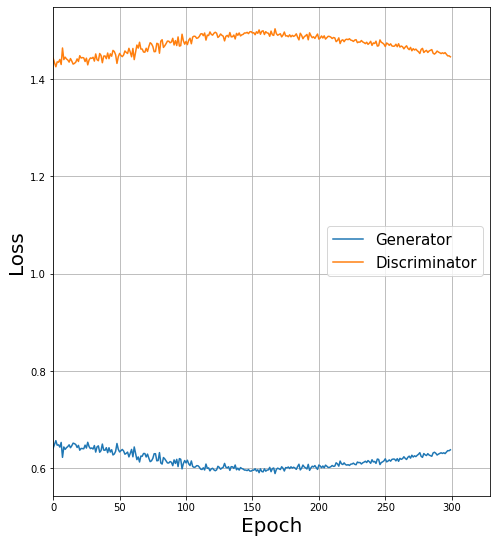

In [39]:
plot_loss(gen_loss_,disc_loss_,epochs_)

In [40]:
def generate_samples( batch_size, shape=None):

  """Generates sample using random inputs
        
            Arguments:
                batch_size: int
                    Number of samples to generate.
                shape: (Optional) tuple of int
                    Reshape the output to the given shape.
        """
  z_batch_shape = (batch_size,) + generator_model.input_shape[1:]
  z = tf.random.normal(z_batch_shape)
  print(z.shape)
  samples = generator_model(z,training=False)
  print(samples)
  # samples = generator_model
  if shape is not None:
    shape = (batch_size,) + shape
    samples = tf.reshape(samples, shape)
  return samples


In [41]:
def predict_gans(x):
  return discriminator_model(x,training=False)

In [42]:
def plot_roc_curve(fpr_list,tpr_list,name='QGANS',title='ROC Curve', with_auc=True,labels=''):
  n = len(fpr_list)
  if labels =='':
    labels = ['']*n

  plt.clf()
  plt.rcParams["font.weight"] = "bold"
  plt.xlabel("Signal Efficiency", fontsize=18,fontweight='bold')
  plt.ylabel("Background Rejection", fontsize=18,fontweight='bold')
  plt.title(title, fontsize=16,fontweight='bold')
  plt.xlim(0.0, 1.0)
  plt.ylim(0.0, 1.0)
  plt.grid(color='gray', linestyle='--', linewidth=1)  
  for fpr,tpr,label in zip(fpr_list, tpr_list, labels):
    if with_auc:
      roc_auc = auc(fpr, tpr)
      label += ', AUC={:.4f}'.format(roc_auc)
    plt.plot(tpr,1-fpr, linestyle='-',label=label,linewidth=2)
  plt.plot([0, 1], [1, 0], linestyle='--', color='black', label=' AUC= 0.5')
  plt.legend(loc='best',prop={'size': 8})    
  return plt 

(50, 5)
tf.Tensor(
[[-0.9091258   0.3013943   0.64887714  0.3879328   0.42643782]
 [-0.90910476  0.29914206  0.60063344  0.58380353  0.33600628]
 [-0.9088734   0.26301703 -0.7744225   0.6525768  -0.45186618]
 [-0.9091069   0.30058286  0.38526592  0.5242065   0.84616196]
 [-0.90869933  0.2379158  -0.14911741  0.8875369   0.43750066]
 [-0.909003    0.29366666  0.06070904 -0.1916327   0.8963473 ]
 [-0.9089673   0.2871497   0.14394878  0.11873573 -0.02762513]
 [-0.90910214  0.2815028  -0.0837004   0.4147977   0.19475392]
 [-0.9091575   0.29158717  0.5190649   0.5647564   0.5995541 ]
 [-0.90905726  0.3001228   0.64772576 -0.10774976  0.93104154]
 [-0.9091028   0.27425462  0.4617133   0.24453399  0.8324689 ]
 [-0.9090357   0.29028776  0.17502147  0.32646576  0.5560749 ]
 [-0.9091313   0.28568667  0.65495026  0.3490313   0.91993517]
 [-0.9089638   0.2873082  -0.0991048   0.04198976  0.08493397]
 [-0.9090885   0.27208477  0.07214075  0.0656357   0.7971817 ]
 [-0.90912217  0.3036718  -0.4769261

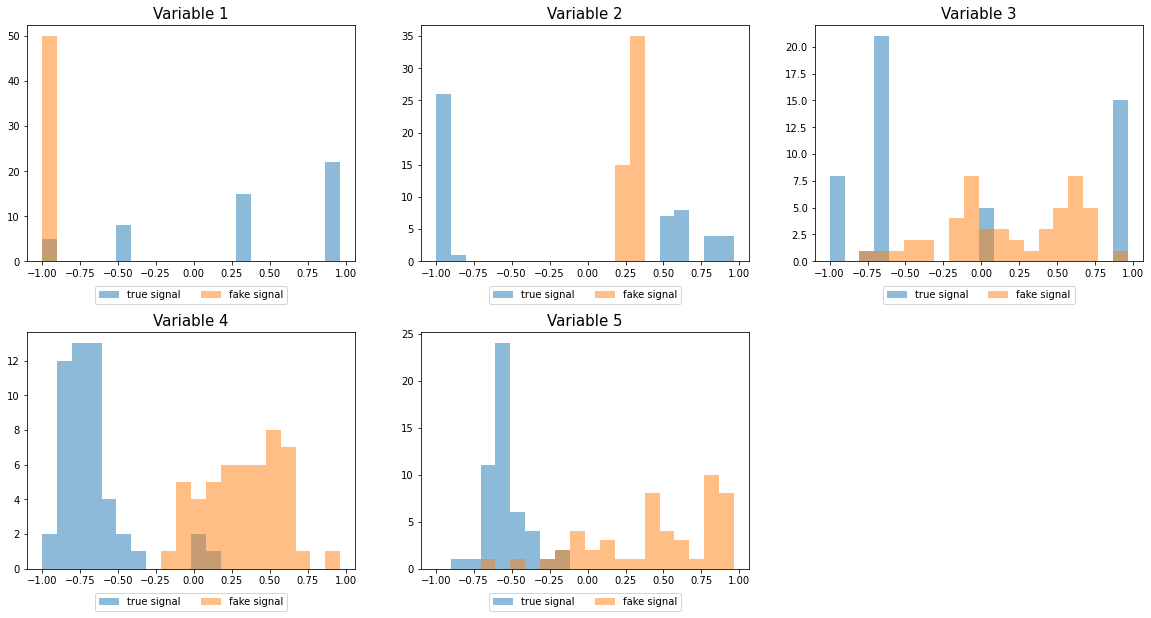

In [43]:
samples = generate_samples(batch_size=50,shape=(5,)).numpy()
make_plots([X_train_1, samples], ['true signal', 'fake signal'])
# print(type(samples))
# print(samples)

In [44]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
def test_gans( x, y, plot=True):
  score = predict_gans(x)
  # print(y)
  print(score)
  fpr, tpr, thresholds = roc_curve(y, score)
  roc_auc = auc(fpr, tpr)
  print("AUC = ",roc_auc)
  if plot:
    return plot_roc_curve(fpr_list=[fpr],tpr_list=[tpr], name='QGAN_with_DataReuploading')
  else:
    return roc_auc

tf.Tensor(
[[-0.00110205]
 [-0.00088959]
 [-0.00161676]
 [-0.00161347]
 [-0.0010171 ]
 [-0.00166563]
 [-0.00221297]
 [-0.00164824]
 [-0.00166688]
 [-0.00165928]
 [-0.00106111]
 [-0.00164802]
 [-0.00077655]
 [-0.00160868]
 [-0.00164097]
 [-0.00094002]
 [-0.00161552]
 [-0.00120948]
 [-0.00165291]
 [-0.00164697]
 [-0.0016607 ]
 [-0.00110745]
 [-0.00164882]
 [-0.00115324]
 [-0.00118246]
 [-0.00118715]
 [-0.00104029]
 [-0.00116442]
 [-0.00161617]
 [-0.00116127]
 [-0.00114279]
 [-0.00156236]
 [-0.00153522]
 [-0.0011351 ]
 [-0.00092797]
 [-0.00110611]
 [-0.00159373]
 [-0.00159707]
 [-0.00119156]
 [-0.00164763]
 [-0.00167102]
 [-0.00163678]
 [-0.00115126]
 [-0.00107827]
 [-0.00089822]
 [-0.00113206]
 [-0.00114685]
 [-0.00153108]
 [-0.00164586]
 [-0.00151614]
 [-0.00174786]
 [-0.00122554]
 [-0.00135675]
 [-0.00115302]
 [-0.00102452]
 [-0.00109492]
 [-0.00168227]
 [-0.00096589]
 [-0.00105694]
 [-0.00161244]
 [-0.00108349]
 [-0.00120223]
 [-0.00107887]
 [-0.00106524]
 [-0.00089606]
 [-0.001524  ]

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

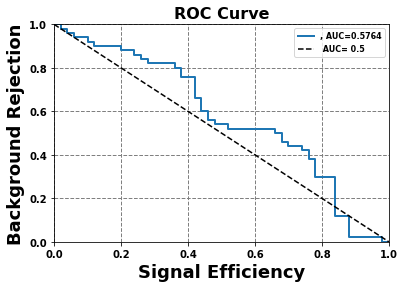

In [45]:
test_gans(X_test,y_test)